<h1><center>Retina AI Take Home Assessment</center></h1>
<h2><center>Data Scientist Role Application</center></h2>
<h3><center>Francis Chen</center></h3>

In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 1. Queries

### i) Sample 10 rows at random
**Pseudo-SQL Code:**
> SELECT * FROM page_table <br>
ORDER BY RANDOM() <br>
LIMIT 10;

**Expected result:** 10 randomly selected rows from the page_table

|visitor_id|visit_date|page_name|
|---|---|---|
|10512|01/01/2014|home|
|10692|09/01/2019|checkout|
|...|...|...|

### ii) Get the list of unique visitor_ids who land on home page
**Pseudo-SQL Code:**
> SELECT DISTINCT visitor_id FROM page_table <br>
WHERE page_name = 'home';

**Expected result:** A list of all unique visitor_id from page_table

|visitor_id|
|---|
|10512|
|10692|
|15092|
|...|

### iii) Get the list of 100 visitors who saw the most unique pages
**Pseudo-SQL Code:**
> SELECT visitor_id, COUNT(page_name) AS unique_pages_visited <br>
FROM (SELECT DISTINCT visitor_id, page_name FROM page_table) <br>
GROUP BY visitor_id <br>
ORDER BY unique_visits DESC <br>
LIMIT 100;

**Expected result:** Table of top 100 unique visitor_id and their corresponding number of unique pages visited where the number of unique pages visited is in descending order.

|visitor_id|unique_pages_visited|
|---|---|
|10512|63|
|10692|59|
|20593|58|
|...|...|

## 2. Analysis

### Modules Initialization and Data Reading
Assume relevant .csv files are saved in their own folder called weekly_sales and the folder is in the same directory as this code.

In [1]:
### Importing Necessary Modules for Data Handling
import pandas as pd
import numpy as np
import datetime as dt
import os
from scipy.stats import norm

### Importing plotly modules for visualization
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

### Assuming data is consistent for all .csv files
parent_directory = os.getcwd()
weekly_sales_folder = '\\weekly_sales'
os.chdir(parent_directory + weekly_sales_folder)
# Reading all .csvs at once
sales_df = pd.concat([pd.read_csv(filename, index_col=0, parse_dates=True) 
                      if '.csv' in filename 
                      else None for filename in os.listdir()])
os.chdir(parent_directory)

### i) Plot the number of sales by day for all 50 weeks

In [2]:
### Grouping data by days and counting occurrences to get total daily sales
daily_sales = sales_df.groupby(pd.Grouper(freq='D')).count().rename(columns = {'purchaser_gender':'DailySales'})
### Generating plotly line chart
data = [go.Scatter(x = daily_sales.index, y = daily_sales.DailySales)]
layout = go.Layout(
    autosize=True,
    width=950,
    title='Daily Sales',
    height=500,
    xaxis=dict(title = 'Date'),
    yaxis=dict(title = 'Sales')
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### ii) On what date was [the sudden change in daily sales]?

In [3]:
### Creating Daily Percent Sales Change
daily_sales_change = daily_sales.pct_change()
# Finding date of sales jump
jump_date = daily_sales_change.idxmax()[0]
jump_value = daily_sales_change.max()[0]
print('The sudden change in sales occurred on {0}'.format(jump_date.strftime('%m/%d/%Y')))
print('by {0}% in sales from the day prior.'.format(round(jump_value*100,2)))

The sudden change in sales occurred on 04/29/2013
by 59.83% in sales from the day prior.


### iii) Is the change in daily sales [...] significant? If so, what is the p-value?

The change in daily sales is statistically significant if we compute the p-value using the z-score of the change.

In [4]:
mean_change = daily_sales_change.mean()[0]
std_change = daily_sales_change.std()[0]
sales_jump_zscore = (jump_value - mean_change)/std_change
p_value = 1 - norm.cdf(sales_jump_zscore)
print('The p-value for this one day change in sales is {}.'.format(p_value))

The p-value for this one day change in sales is 9.86518788881341e-09.


We can also see the significance of this change from a histogram.

In [5]:
### Creating Histogram to see distribution
data = [go.Histogram(x = daily_sales_change.DailySales,
                     name = 'PctDailySalesChange',
                     nbinsx = 30)]
layout = go.Layout(
    title='Sales Change Distribution',
    xaxis=dict(title='Value'),
    yaxis=dict(title='Count'),
    bargap=0.2,
    bargroupgap=0.1,
    width=950,
    height=500)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### iv) Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers?

The best way to see this is to plot the daily sales from both male and female customers separately. From the plot below, we can see that although there is indeed a shift in the proportion of male-vs-female customers, this is not what caused the large change on 4/29/2013. In fact, the increase in sales on that date was even across genders.

In [6]:
### Grouping sales data by day and gender for plotting
daily_sales_mfsplit = sales_df.reset_index().reset_index().set_index('sale_time')
daily_sales_mfsplit = daily_sales_mfsplit.groupby([pd.Grouper(freq='D'),'purchaser_gender']).count().unstack(-1)
daily_sales_mfsplit.columns = daily_sales_mfsplit.columns.get_level_values(1)
# Creating daily sales line plot
trace1 = go.Scatter(y = daily_sales_mfsplit.female,
                    x = daily_sales_mfsplit.index,
                    name = 'Sales from Females')
trace2 = go.Scatter(y = daily_sales_mfsplit.male,
                    x = daily_sales_mfsplit.index,
                    name = 'Sales from Males')
data = [trace1, trace2]
layout = go.Layout(
    title='Daily Sales By Gender',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Sales'),
    width=950,
    height=500
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 3. Modeling

### Modules Initialization and Data Handling
Note that data exploration and validation was done before any modeling. The work and code can be found in the Supplementary Details section of this report.

In [7]:
# Truncating Warning Messages for Display
import warnings
warnings.filterwarnings('ignore')

### Importing necessary modules for ML
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
### Reading in file assuming file is in same folder as code
modeling_df = pd.read_csv('fdds_coding_challenge.csv', dtype={'user_id': np.int32,
                                                              'post_code': str},
                          parse_dates = ['first_order_date'],
                          index_col = 0)

### Preprocessing Data
# Separating categorical and numerical columns
ignore_cols = ['city', 'post_code', 'first_order_date']
cat_cols = list(filter(lambda col: modeling_df[col].dtype == object 
                       and col not in ignore_cols,
                       modeling_df.columns.tolist()))
num_cols = list(filter(lambda col: modeling_df[col].dtype == float, 
                       modeling_df.columns.tolist()))
# Before removing null values, convert categorical variables on full
# data set so that labels are maintained.
encoded_categorical = pd.get_dummies(modeling_df[cat_cols], drop_first = True)
# Since numerical values are similar magnitudes, no need to standardize
# them to find the most significant feature. Thus, only need to join
# numerical with encoded categorical
modeling_df = pd.concat([encoded_categorical,
                         modeling_df[num_cols]], axis = 1).dropna()
# Adding extra dummy variable for channel_credit feature
# to account for the missing values in that feature
# even though NAs have been dropped
modeling_df['channel_credit_NaN'] = 0

C:\Users\Fang\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



### i) What is the greatest predictor of Customer Lifetime Value?
**90d_total_revenue** is the greatest predictor of Customer Lifetime Value.

I approached this question in two parts, an OLS regression to determine the most significant feature and a Random Forest Regression to confirm. Since the data set is larger, I performed multiple regressions by resampling and determining the greatest predictor as the feature that is consistently the most statistically significant from the coefficient estimates. 

#### OLS for Determining Greatest Predictor

In [8]:
### Defining Function for OLS Regression
def ols_significance(df, y_col, n_samples, sig_coeffs_only = True):
    # Randomly selecting n_samples from full data set
    current_sample = df.sample(n_samples)
    # Creating dataframes for X and Y features
    x_sample = current_sample[list(filter(lambda x: x != y_col, 
                                          current_sample.columns.tolist()))]
    y_sample = current_sample[y_col]
    # Fitting OLS model without intercept
    ols_model = sm.OLS(y_sample,x_sample).fit()
    
    # Storing OLS coefficient summary into dataframe for output
    ols_coeff = pd.read_html(ols_model.summary().tables[1].as_html(), 
                                 header = 0, index_col = 0)[0]
    # Converting t values to absolutes since magnitude
    # is most important for this statistic
    ols_coeff['t'] = abs(ols_coeff['t'])
    if sig_coeffs_only:
        # Finding the top 5 features in terms of significance
        # and ordering them in descending order of significance
        significant_coeff = ols_coeff[ols_coeff['P>|t|'] < 0.05]
        significant_coeff = significant_coeff.sort_values('t', ascending = False).head()
        return significant_coeff, None, None
    else:
        # If user also wants to return the OLS model
        ols_summary = pd.read_html(ols_model.summary().tables[0].as_html(), 
                                 header = 0, index_col = 0)[0]
        return ols_coeff[ols_coeff['P>|t|'] < 0.05], ols_summary, ols_model

In [9]:
### Running multiple regressions
# Sampling 20,000 data points each regression
n_samples = 20000
# Performing 30 trials to find greatest predictor
ols_trials = 30
y_col = 'predicted_total_ltv'
# Initializing loop
rankings_dfs = []
tval_dfs = []
pval_dfs = []
for i in range(1, ols_trials + 1):
    curr_trial_string = 'trial{}_'.format(i)
    curr_sig, curr_summary, curr_model = ols_significance(modeling_df, y_col, n_samples, sig_coeffs_only = True)
    # Creating feature rankings for each regression
    feature_rankings = curr_sig.reset_index().reset_index().iloc[:,:2]
    feature_rankings.columns = [curr_trial_string + 'score','significant_feature']
    feature_rankings = feature_rankings.set_index('significant_feature')
    feature_rankings[curr_trial_string + 'score'] = feature_rankings[curr_trial_string + 'score'] + 1
    # Adding statistics that indicate significance
    feature_t = curr_sig[['t']]
    feature_t.columns = [curr_trial_string + 'tval']
    feature_p = curr_sig[['P>|t|']]
    feature_p.columns = [curr_trial_string + 'pval']
    rankings_dfs.append(feature_rankings)
    tval_dfs.append(feature_t)
    pval_dfs.append(feature_p)
# Aggregating regression trials
ranking_df = pd.concat(rankings_dfs,axis = 1)
tval_df = pd.concat(tval_dfs,axis = 1)
pval_df = pd.concat(pval_dfs,axis = 1)
# Summarizing regression trials
feature_rankings = pd.DataFrame(ranking_df.fillna(5).mean(axis = 1)).sort_values(0).head()
feature_rankings.columns = ['avg_significance_rank']
feature_tvals = pd.DataFrame(tval_df.mean(axis = 1))
feature_tvals.columns = ['avg_t_score']
feature_pvals = pd.DataFrame(abs(pval_df.mean(axis = 1)))
feature_pvals.columns = ['avg_p_value']
feature_rankings = feature_rankings.join(feature_tvals.join(feature_pvals))

In [10]:
feature_rankings.head(3)

,avg_significance_rank,avg_t_score,avg_p_value
90d_total_revenue,1.0000,60.3351,0.0000
first_order_total_revenue,2.0000,28.0690,0.0000
first_order_type_subscription,3.0000,20.9350,0.0000


#### Random Forest Regression for Feature Significance

In [11]:
### Building Random Forest Regression
rf = RandomForestRegressor(bootstrap = True,
                           n_estimators = 100,
                           criterion = 'mse',
                           max_depth = 10,
                           max_features = 'sqrt')
# Splitting into dependent and independent variables
y_col = 'predicted_total_ltv'
x_sample = modeling_df[list(filter(lambda x: x != y_col, 
                                   modeling_df.columns.tolist()))]
y_sample = modeling_df[y_col]
# Fitting Random Forest on data
rf_fitted = rf.fit(x_sample, y_sample)
# Creating DataFrame for feature importance metric
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_sample.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

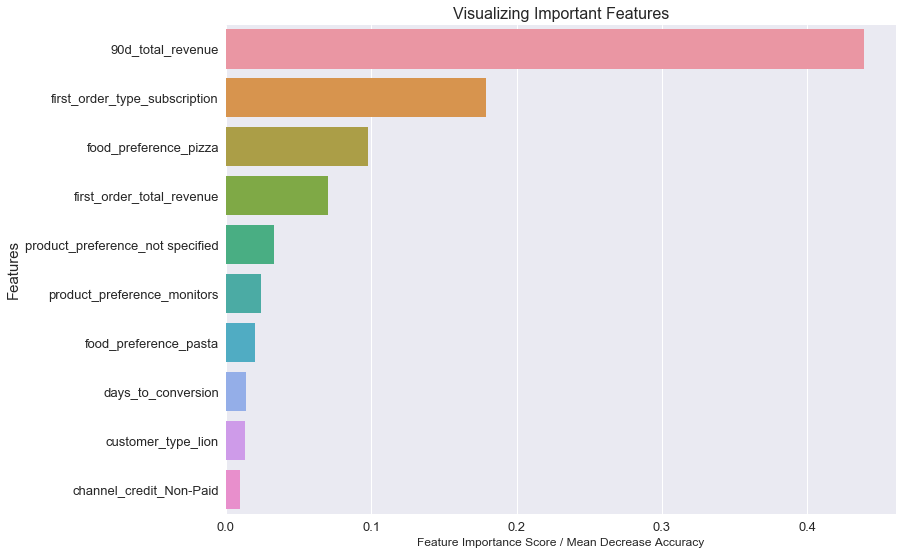

In [12]:
### Plotting Feature Importance
import seaborn as sns
fig, ax = plt.subplots(figsize = (12,9))
sns.barplot(ax = ax, x = feature_importances.importance.head(10), 
            y = feature_importances.head(10).index)
plt.xlabel('Feature Importance Score / Mean Decrease Accuracy',
           size = 12)
ax.tick_params(labelsize = 13)
plt.ylabel('Features', size = 15)
plt.title("Visualizing Important Features", size = 16)
plt.legend()
plt.show()

### ii) How confident are you in your results? How do you measure this?
I am very confident in finding that **90d_total_revenue** is the most significant predictor for Customer Lifetime Value. This is because in both parametric and non-parametric approaches, this feature was the most important. One way to measure this is by using the t-score and p-values generated from the OLS regression. The larger in magnitude of the t-value and/or the lower the value of the p-value, the more significant the variable in prediction.

### iii) Fit a least squares model to days_to_conversion, first_order_total_reveue, and 90d_total_revenue.

In [13]:
### Using statsmodels package to fit a least squares regression without intercept
y_col = 'predicted_total_ltv'
ols_x = modeling_df[['days_to_conversion', 'first_order_total_revenue', '90d_total_revenue']]
ols_y = modeling_df[y_col]
ols_model = sm.OLS(ols_y,ols_x).fit()
# Model Summary
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     predicted_total_ltv   R-squared:                       0.457
Model:                             OLS   Adj. R-squared:                  0.457
Method:                  Least Squares   F-statistic:                 6.200e+04
Date:                 Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                         00:09:05   Log-Likelihood:            -1.4523e+06
No. Observations:               221107   AIC:                         2.905e+06
Df Residuals:                   221104   BIC:                         2.905e+06
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
days_to_conversion            0.0912      0.004     23.782      0.000       0.084       0.099
first_order_total_revenue    -1.8122      0.023    -77.518      0.000      -1.858      -1.766
90d_total_revenue             4.0128      0.017    238.550      0.000       3.980       4.046
==============================================================================
Omnibus:                    71232.664   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           366272.538
Skew:                           1.474   Prob(JB):                         0.00
Kurtosis:                       8.574   Cond. No.                         7.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the OLS Regression results, we can see that the **days_to_conversion**, **first_order_total_reveue**, and **90d_total_revenue** features can explain 45.7% (the R-squared value) of the variation in **predicted_total_ltv**. What can be concluded from these results is that higher initial spending from a customer will lead to them having higher lifetime values for Animal Cookie. Thus, proactive campaigns to retain customers would be most effective early in a customer's purchasing history.

### iv) Approaching Data Augmentation for Problem
I would approach categorizing users into personas as an unsupervised learning problem. The goal would be to identify clusters of customers that share similar characteristics and label these clusters as personas. I would consider an agglomerative hierarchical clustering algorithm using a complete-linkage criterion. I would consider most of the features within the data set except for **first_order_date** and **post_code**. However, it may be feasible to derive a feature from the **first_order_date** such as **season_of_year** to include in the labeling.
The approach to implement this would be to:
1.	Load and clean data – address any missing values.
2.	Partition data into a training and test set where the test set will be used to measure a pre-defined evaluation metric.
3.	Define a linkage criterion and distance metric and address categorical variables by applying a matching approach
4.	Pass training data through algorithm to arrive at personas
5.	Evaluate on model on test data.


### v) Advantages and Disadvantages of Approach
**Advantages**:
-	The output of hierarchical clustering is a dendrogram that provides a structure that is more informative and easier to understand compared to a set of flat clusters returned by something such as k-means. This allows it to be more suitable for labeling customers into personas since comprehensibility is an important element.
-	No information about class membership or other response variables are used to obtain the graphical representation, making this method suitable for the task of hypothesis generation.

**Disadvantages**:
-	Sensitive to linkage metric and distance metric selection.
-	Sensitive to outliers.

An alternative strategy could be to use Principal Component Analysis to determine variables that are characteristic for specific sample groups. Although PCA is not directly trying to maximize the separation between groups, in many high-dimensional real-world data sets, the most dominant patterns are those that separate different subgroups. Thus, the results from PCA support similar interpretations.


### vi) How to Measure Success of Labeling Scheme
Since each user does not have a "ground truth" persona to assess the accuracy of this clustering, I would approach measuring the success of this labeling scheme by using the test set of data that was left out. The test data would have no information “leaked” from the model fitting and success would be a measure of how consistent the persona labels persist with new observations. I would fit the trained algorithm onto the test data and observe the user labels. If the clusters formed on the test data are very similar to the trained clusters, e.g., the distribution of features are similar for the newly labeled test observations compared to that of the labeled trained observations. As well, high intra-cluster similarity and low inter-cluster similarity on both training and test data would be a good measure of how well-separated the clusters are.

## 4. Visualization and Narratives

### Creating network graph of organization's employees

In [14]:
### Importing necessary modules
import networkx as nx
### Loading data assuming data file is located in same folder as code
org_df = pd.read_csv('new_org_data.csv')
### Self joining employees id to get manager names
org_df = pd.merge(org_df, org_df[['employee_id','employee_name']], 
                  how='left', 
                  left_on=['manager_employee_id'], right_on=['employee_id'],
                  suffixes=('', '_manager'))
del org_df['employee_id_manager']
org_df.columns = ['employee_id','manager_id','employee_name','manager_name']
full_org_df = org_df.copy()
org_df = org_df[org_df.employee_id.isin(org_df.manager_id.drop_duplicates())]

Building directed network graph of employees where direction flows from manager to employee such that the head of the organization will be the root of the network. Note that organization data was filtered such that only employee_ids that are also manager_ids are kept since the head of the organization must be a manager.

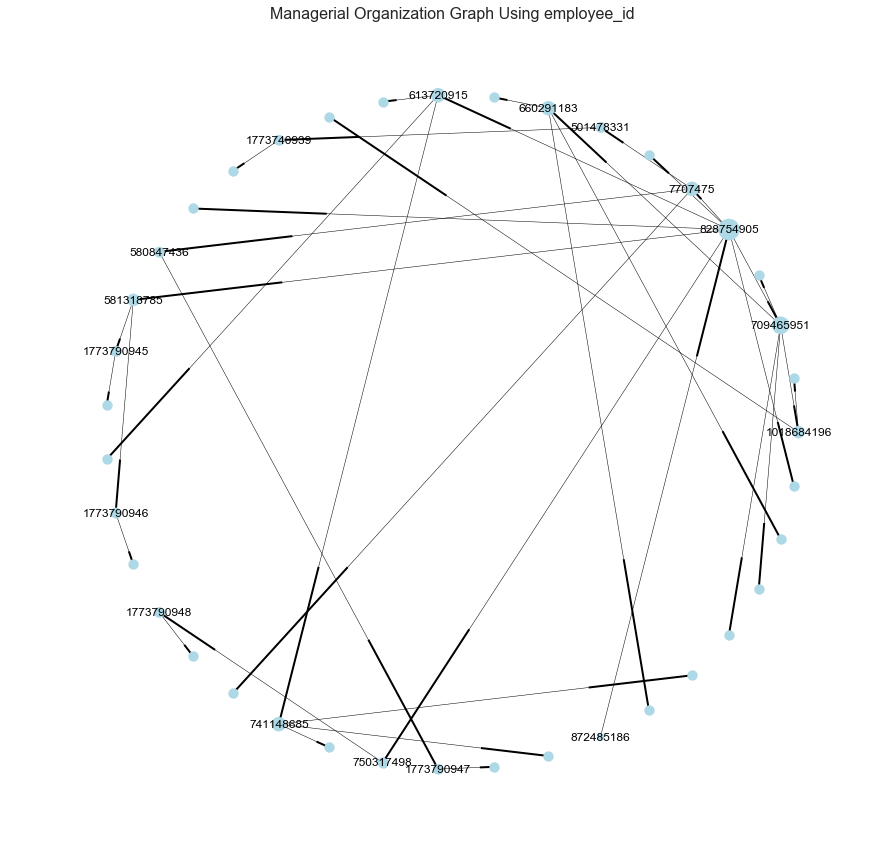

In [15]:
### Creating graph object
plt.figure(figsize=(15, 15))
source_col = 'manager_id'
target_col = 'employee_id'
g = nx.from_pandas_dataframe(org_df, source = source_col, target = target_col,
                             edge_attr = True,
                             create_using=nx.DiGraph())
# Create a layout for our nodes 
layout = nx.circular_layout(g)
# Draw the parts we want
nx.draw_networkx_edges(g, layout, arrowstyle='->',
                       arrowsize = 10, 
                       edge_cmap=plt.cm.Blues, width = 0.5)
# Drawing nodes for managers
managers = [node for node in g.nodes() if node in org_df[source_col].unique()]
size = [g.degree(node)*50 for node in g.nodes() if node in org_df[source_col].unique()]
nx.draw_networkx_nodes(g, layout, nodelist=managers, node_size=size, node_color='lightblue')
# Drawing nodes for employees
employees = [node for node in g.nodes() if node in org_df[target_col].unique()]
nx.draw_networkx_nodes(g, layout, nodelist=employees, node_size=100, node_color='lightblue')
# Labeling managers
managers_dict = dict(zip(managers, managers))
nx.draw_networkx_labels(g, layout, labels=managers_dict)
plt.axis('off')
plt.title("Managerial Organization Graph Using employee_id", size = 16)
plt.show()

### i) Who is the head of the organization?

In [16]:
org_df[org_df['manager_id'] == 872485186]

,employee_id,manager_id,employee_name,manager_name
92,828754905,872485186,Giancarlo Avila,NaN


From the above chart, it appears that the head of the organization would be the employee with ID 872485186 (no name is provided) since they have no managers (indicated by the lack of bold facing lines towards them) and they are manager to the employee with ID 828754905, Giancarlo Avila, who must be second in command.

### ii) What is the maximum depth of the organization?
Given that the employee with ID 872485186 is the root of the directed graph (the head of the company), using the shortest_path() function of the networkx module and finding the maximum out of all paths:

In [17]:
### Creating graph of entire organization including non-manager employees
full_org_g = nx.from_pandas_dataframe(full_org_df, source = source_col, target = target_col,
                                      edge_attr = True,
                                      create_using=nx.DiGraph())
### Finding max depth from head of organization
max_depth = max(nx.shortest_path_length(g, 872485186).values())
print('The maximum depth of this organization is: {}'.format(5))

The maximum depth of this organization is: 5


### iii) What is the maximum team size?
Assuming a team is a number of employees who have one manager and the team size is the number of employees including the manager they work for, then:

In [47]:
### Finding node with max degree from the full organization network
max_degree_node = max(dict(full_org_g.degree()).items(), key = lambda x : x[1])
largest_team_df = full_org_df[full_org_df.manager_id == max_degree_node[0]].reset_index(drop = True)
print('The maximum team size is {},'.format(max_degree_node[1]))
print('which is managed by {0}, manager_id {1},'.format(largest_team_df.loc[0,'manager_name'],
                                                       max_degree_node[0]))
print('where she manages {} employees.'.format(len(largest_team_df)))
### Displaying table of employees in the largest team
largest_team_df

The maximum team size is 11,
which is managed by Luca Ashley, manager_id 709465951,
where she manages 10 employees.


,employee_id,manager_id,employee_name,manager_name
0,4203366,709465951,Jonathan Compton,Luca Ashley
1,122603511,709465951,Krish Wagner,Luca Ashley
2,545188806,709465951,Londyn Donaldson,Luca Ashley
3,660291183,709465951,Kendal Stark,Luca Ashley
4,674307406,709465951,Ivan Moses,Luca Ashley
5,779305292,709465951,Yurem Bailey,Luca Ashley
6,1018684196,709465951,Amari Carpenter,Luca Ashley
7,1055173655,709465951,Aryan Zuniga,Luca Ashley
8,1353484352,709465951,Shaylee Buckley,Luca Ashley
9,1597838229,709465951,Macey Montoya,Luca Ashley


## Supplementary Details

### Understand Section
Initial investigation of the data was examining missing values and their impact on the variable of interest, **predicted_total_ltv**.

In [19]:
### Reading in Data
modeling_df = pd.read_csv('fdds_coding_challenge.csv', dtype={'user_id': np.int32,
                                                              'post_code': str},
                          parse_dates = ['first_order_date'],
                          index_col = 0)
### Determining number of missing values from each feature column
missing_values = pd.DataFrame(modeling_df.isnull().sum()).rename(columns = {0:'NullValueCount'})
missing_values[missing_values.NullValueCount != 0]

,NullValueCount
days_to_conversion,152748
channel_credit,152748
first_order_source,18932
first_order_medium,18901


In [20]:
### Quick Data Summaries
# Storing categorical and numerical feature lists separately for later preprocessing
# Note that first_order_date is initially assumed as insignificant and that
# days_to_conversion is assumed to already capture any information from
# first_order_date.
cat_cols = list(filter(lambda col: modeling_df[col].dtype == object, 
                       modeling_df.columns.tolist()))
num_cols = list(filter(lambda col: modeling_df[col].dtype == float, 
                       modeling_df.columns.tolist()))

### Examine Numerical Data Summaries
modeling_df.describe()

,days_to_conversion,first_order_total_revenue,90d_total_revenue,predicted_total_ltv
count,"221,107.0000","373,855.0000","373,855.0000","373,855.0000"
mean,34.0400,32.9236,44.2032,138.1647
std,94.6382,20.0193,31.1829,193.5994
min,0.0000,0.0000,0.0000,0.0000
25%,0.0000,19.9500,24.9500,18.2179
50%,0.0000,26.9500,34.9500,47.4250
75%,15.0000,39.9000,54.9000,187.3657
max,"1,242.0000",479.2000,658.7500,"4,437.1502"


In [21]:
### Examining Categorical Data Summaries
modeling_df[cat_cols].describe().T

,count,unique,top,freq
customer_type,373855,5,lion,344999
first_order_type,373855,3,one-time,220596
region,373855,5,South,132350
subregion,373855,10,South Atlantic,78469
state,373855,59,CA,50202
city,373855,14003,NEW YORK,2944
post_code,373855,23970,77494,273
product_preference,373855,5,monitors,209362
food_preference,373855,4,pizza,123317
channel_credit,221107,10,Paid Social,100852


From the categorical table summary, we see that the majority of the missing values are in the **channel_credit** feature, which is directly tied to missing values in the **days_to_conversion** feature. A solution to address the missing values in **channel_credit** is to replace them with a label of '(none)' in case removing the missing values is not a choice.

As well, the **city** and **post_code** features will be removed during modeling to save on computation and we can assume that most of the geographic information relevant to **predicted_total_ltv** is embedded in **region**, **subregion**, and **state**.

In [22]:
### Examining distribution of data with no missing values vs data with missing values
no_missing = modeling_df.dropna()
only_missing = modeling_df[modeling_df.index.isin(no_missing.index) == False]

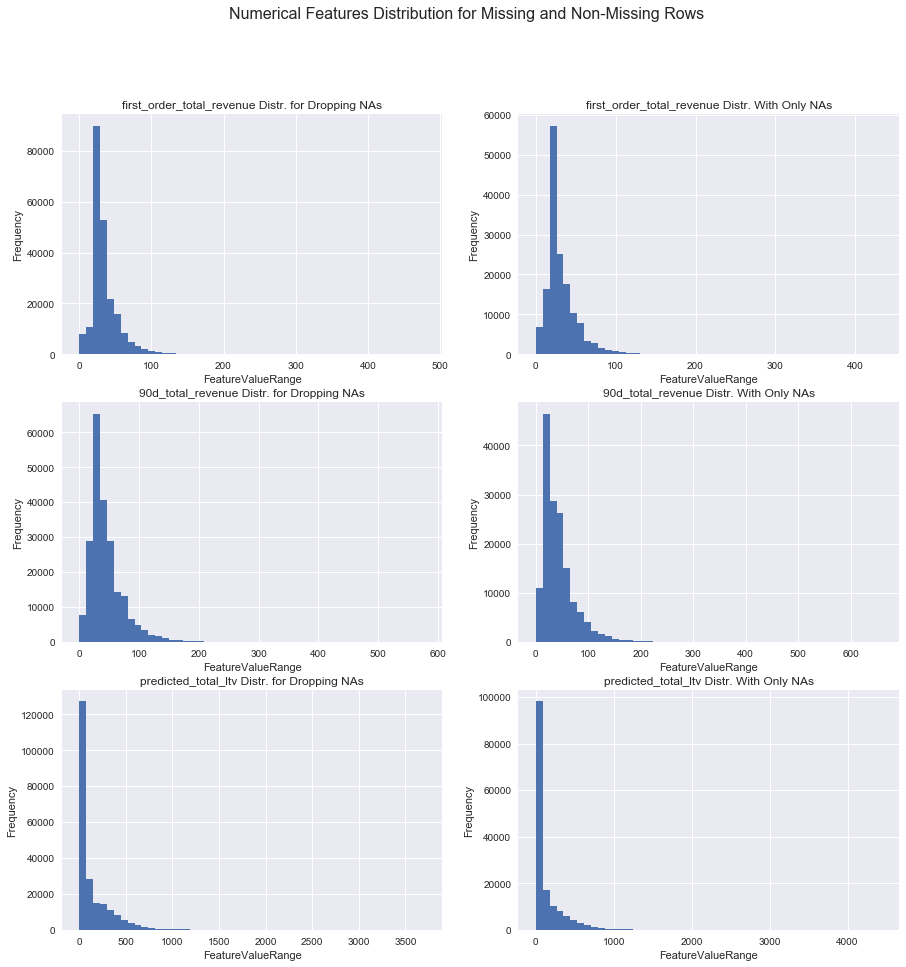

In [23]:
### Creating histograms for numerical data
sub_rows = 3
sub_cols = 2

f, axarr = plt.subplots(sub_rows, sub_cols, figsize = (15,15))

for i in range(sub_rows):
    # Note that days_to_conversion is not plotted since
    # this feature is the one containing the missing
    # values.
    col = list(filter(lambda x: x != 'days_to_conversion', num_cols))[i]
    
    axarr[i, 0].hist(no_missing[col], bins = 50)
    axarr[i, 0].set_title('{} Distr. for Dropping NAs'.format(col))

    axarr[i, 1].hist(only_missing[col], bins = 50)
    axarr[i, 1].set_title('{} Distr. With Only NAs'.format(col))

for ax in axarr.flat:
    ax.set(xlabel='FeatureValueRange', ylabel='Frequency')
f.suptitle('Numerical Features Distribution for Missing and Non-Missing Rows',
           size = 16)
plt.show()

Given that the distributions for the numerical values are similar between the rows with missing values and those without, it is safe to simply remove the missing values without impacting the evaluation of the strongest predictor for **predicted_total_ltv**.